# Querying Data

In [1]:
from optimade.client import OptimadeClient
import numpy as np
import pandas as pd
import mendeleev as md
from collections import Counter

`newNEl5.pkl` has the logs of the query optimizer code. We pick the entry with the best fitness value (i.e lowest std(count)/mean(count))

In [3]:
dfQry = pd.read_pickle('/u/fs1/kj419/optimadeScripts/newNEl5.pkl')
bestQry = dfQry.iloc[dfQry['Fitness Value'].argmin(), :]
print(bestQry)

Fitness Value                                             0.666366
Count Mean                                             1446.666667
Count Std                                               787.110468
Count List                                       [2199, 1781, 360]
Input            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
Filter Query     elements HAS ANY "W","Al","Cd","Zn" AND NOT el...
Provider List    [http://oqmd.org/optimade/, https://nomad-lab....
Name: 869, dtype: object


We then set the filter and provider list based on this entry

In [4]:
client = OptimadeClient()
filterQry = bestQry['Filter Query']

In [5]:
client.base_urls = bestQry['Provider List']
client.count(filter=filterQry)

Output()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Counting results for structures/?filter=elements HAS ANY "W","Al","Cd","Zn" AND NOT elements HAS ANY "B", "Cl", │
│ "F", "H", "N", "O", "S", "Se" AND nelements>=5                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Detected a running event loop (e.g., Jupyter, pytest). Running in synchronous mode.

Error: Provider 'http://oqmd.org/optimade/' returned: The read operation timed out

Warning: http://oqmd.org/optimade/ did not return a value for `meta->data_returned`, unable to count results.

{'structures': {'elements HAS ANY "W","Al","Cd","Zn" AND NOT elements HAS ANY "B", "Cl", "F", "H", "N", "O", "S", "Se" AND nelements>=5': {'http://oqmd.org/optimade/': None,
   'https://nomad-lab.eu/prod/rae/optimade/': 1781,
   'https://optimade-misc.odbx.science': 360}}}

We can query the databases for a maximum of 2200 entries to get all the relevant entries. However, there is as issue with NOMAD when querying more than 1760 entries with this filter. Also, OQMD sometimes times out during the `get` operation. Hence we limit the max resutls to 1700 until the DB issues are resolved.

In [6]:
client.max_results_per_provider = 1760
respFields = ["chemical_formula_descriptive", "species_at_sites","lattice_vectors"]
resStruct = client.get(filter=filterQry.strip(), response_fields=respFields)
providerList = list(resStruct['structures'][filterQry].keys())

Output()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing query structures/?filter=elements HAS ANY "W","Al","Cd","Zn" AND NOT elements HAS ANY "B", "Cl",     │
│ "F", "H", "N", "O", "S", "Se" AND nelements>=5                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Detected a running event loop (e.g., Jupyter, pytest). Running in synchronous mode.

KeyboardInterrupt: 

# Processing and density calc
A Pandas DataFrame is used to store the data obtained as JSON from the DBs. Then lattice vectors and information about species at site is used to calculate density

In [39]:
df = pd.DataFrame(columns=respFields)
df.attrs['Filter Query'] = filterQry
df.attrs['Providers List'] = client.base_urls
df.astype({'chemical_formula_descriptive':str, 'species_at_sites':object, 'lattice_vectors':object})

,chemical_formula_descriptive,species_at_sites,lattice_vectors


In [40]:
for provider in resStruct['structures'][filterQry].keys():
    for entry in resStruct['structures'][filterQry][provider]['data']:
        if type(entry['attributes']['species_at_sites'])==list:
            df = df.append({'provider':provider,
                            'id':entry['id'],
                            'chemical_formula_descriptive':entry['attributes']['chemical_formula_descriptive'],
                            'species_at_sites':entry['attributes']['species_at_sites'],
                            'lattice_vectors':np.array(entry['attributes']['lattice_vectors'])}, ignore_index=True)

In [41]:
densToSIFactor = (1.6605402E-27/1E-30)
df['volume ang^3'] = df.apply(lambda row: np.linalg.det(row['lattice_vectors']), axis=1)
df['mass au'] = df.apply(lambda row: sum([eval(f'md.{elem}.atomic_weight') for elem in row['species_at_sites']]), axis=1)
# df['mass au'] = df.apply(lambda row: sum([md.element(elem).atomic_weight for elem in row['species_at_sites']]), axis=1) #Less dodgy code but much slower
df['density au/ang^3'] = df.apply(lambda row: row['volume ang^3']/row['mass au'], axis=1)
df['density kg/m^3'] = df.apply(lambda row: row['density au/ang^3']*densToSIFactor, axis=1)
df['composition'] = df.apply(lambda row: dict(pd.Series(row['species_at_sites']).value_counts(normalize=True)), axis=1)

In [42]:
allElem = set([])
for row in df['composition']:
    allElem.update(list(row.keys()))
allElem = list(allElem)

In [43]:
def compVecVal(elem, compDict):
    if elem in compDict.keys():
        return compDict[elem]
    else:
        return 0.0

# Feature generation for ML

In [44]:
df['compVec'] = df.apply(lambda row: [compVecVal(elem, row['composition']) for elem in allElem], axis=1) #can be made fater? Use sparse vector for compVec?

# ML

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib_venn as vn
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.legend_handler import HandlerTuple
colVals = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray']


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

As an exemplar ML technique, a Random Forest Regressor is used

In [3]:
def getModel(X_train, y_train):
    pipe = make_pipeline(RandomForestRegressor())
#     pipe = make_pipeline(MLPRegressor(hidden_layer_sizes=(20,20,),max_iter=1000))
    pipe.fit(X_train, y_train)
    return pipe

In [4]:
df = pd.read_pickle('exampleTrain3prov2.pkl')
providerList = list(df['provider'].unique())

Splitting data for training and testing

In [5]:
X_train = [[] for x in range(len(providerList)+1)]
y_train = [[] for x in range(len(providerList)+1)]
X_test = [[] for x in range(len(providerList)+1)]
y_test = [[] for x in range(len(providerList)+1)]
models = [[] for x in range(len(providerList)+1)]

Model training and prediction

In [6]:
for idx, provider in enumerate(providerList):
    Xtemp = list(df[df['provider']==provider]['compVec'])
    ytemp = list(df[df['provider']==provider]['density kg/m^3'])
    X_train[idx], X_test[idx], y_train[idx], y_test[idx] = train_test_split(Xtemp, ytemp, random_state=2, test_size=0.8)
    models[idx] = getModel(X_train[idx], y_train[idx])
    

X_train[-1] = [item for sublist in X_train[:-1] for item in sublist]
y_train[-1] = [item for sublist in y_train[:-1] for item in sublist]
X_test[-1] = [item for sublist in X_test[:-1] for item in sublist]
y_test[-1] = [item for sublist in y_test[:-1] for item in sublist]
models[-1] = getModel(X_train[-1], y_train[-1])

rsq = []
for model in models:
    rsq.append(model.score(X_test[-1], y_test[-1]))
    
barLab = [f'P{idx+1}' for idx,_ in enumerate(providerList)]
barLab.append('C')

In [7]:
df['Unique Elem'] = df.apply(lambda row: set(row['species_at_sites']),axis =1)

In [8]:
allElemList = [[] for x in providerList]
for idx, provider in enumerate(providerList):
    for listVal in df['species_at_sites'][df['provider']==provider]:
        allElemList[idx]+=listVal

dictAllElem = [dict(pd.Series(listVal).value_counts(normalize=True)) for listVal in allElemList]

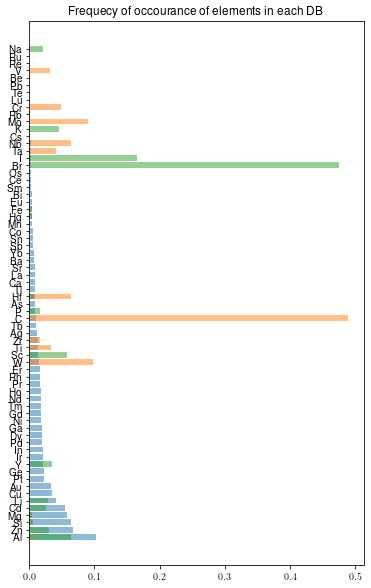

In [9]:
plt.figure(figsize=(6, 10))
ax = plt.subplot()
for idx, dicts in enumerate(dictAllElem):
    ax.barh(list(dicts.keys()), dicts.values(), alpha =0.5, label = barLab[idx], color=colVals[idx])
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_title('Frequecy of occourance of elements in each DB', fontweight='bold')
plt.show()

In [10]:
setElems = [set([]) for _ in providerList]
for idx, provider in enumerate(providerList):
    for setVal in df['Unique Elem'][df['provider']==provider]:
        setElems[idx].update(setVal)

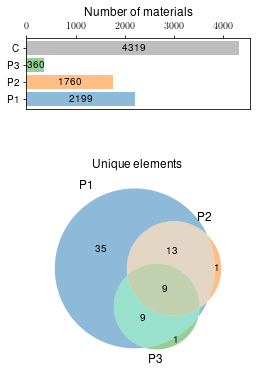

In [11]:
fig, ax = plt.subplots(2, figsize=(4,6), gridspec_kw={'height_ratios': [1.5, 4]})
p = ax[0].barh(barLab, [len(y_train[idx])+len(y_test[idx]) for idx,_ in enumerate(y_test)], color=colVals, alpha=0.5)
ax[0].bar_label(p, fmt='%.2d', label_type='center')
ax[0].set_title('Number of materials')
ax[0].xaxis.tick_top()

vn.venn3([setElems[0], setElems[1], setElems[2]], barLab, set_colors=colVals, alpha=0.5, ax=ax[1])
ax[1].set_title('Unique elements')
plt.subplots_adjust(hspace=0.5)
# plt.savefig('countVenn.pdf', bbox_inches='tight')

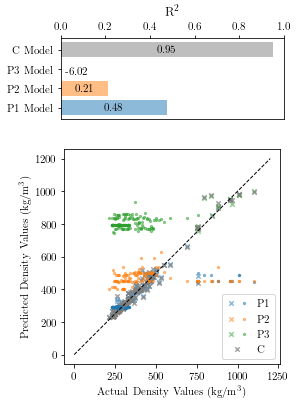

In [21]:
fig, ax = plt.subplots(2, figsize=(4,6), gridspec_kw={'height_ratios': [1.5, 4]})
p = ax[0].barh([lab+' Model' for lab in barLab], rsq, color=colVals, alpha=0.5)
ax[0].bar_label(p, fmt='%.2f', label_type='center')
ax[0].text(0.02, 2-0.25, f'{rsq[2]:.2f}')
ax[0].set_title('R$^2$')
ax[0].set_xlim(0, 1)
ax[0].xaxis.tick_top()


samps = df[['compVec', 'density kg/m^3', 'provider']].sample(n=200, random_state=2)
compVecSamps = list(samps['compVec'])
actDens = list(samps['density kg/m^3'])
sampProvs = list(samps['provider'])

mkrSize1 = 20
mkrSize2 = 5
p = []
for idx, model in enumerate(models):
    if idx != 3:   
        p.append(ax[1].scatter(samps['density kg/m^3'][samps['provider']==providerList[idx]],
                      model.predict(list(samps['compVec'][samps['provider']==providerList[idx]])),
                      s=mkrSize1, alpha=0.5, edgecolors=None, marker = 'x'))
    else:
        p.append(ax[1].scatter(samps['density kg/m^3'],
                      model.predict(list(samps['compVec'])),
                      s=mkrSize1, alpha=0.7, edgecolors=None, marker = 'x', fc='tab:grey'))

plt.gca().set_prop_cycle(None)
for idx, model in enumerate(models[:-1]):
    p.append(ax[1].scatter(samps['density kg/m^3'][samps['provider']!=providerList[idx]],
                  model.predict(list(samps['compVec'][samps['provider']!=providerList[idx]])),
                  s=mkrSize2, alpha=0.5, edgecolors=None, marker = 'o'))


ax[1].plot((0,1200), (0, 1200), 'k--', linewidth=1)

ax[1].axis('tight')
ax[1].set_xlim(0, 1200)
ax[1].set_ylim(0, 1200)
ax[1].set_ylabel('Predicted Density Values (kg/m$^3$)')
ax[1].set_xlabel('Actual Density Values (kg/m$^3$)')
ax[1].legend([(p[0], p[4]), (p[1], p[5]), (p[2], p[6]), p[3]], barLab, 
          handler_map = {tuple: HandlerTuple(None)})
# ax[1].legend(loc='upper left', ncol=2,columnspacing = 0, fontsize="small")
# plt.subplots_adjust(hspace=0.3)
ax[1].axis('equal')
ax[1].axis('tight')
ax[1].axis('square')

# plt.savefig('scatterPlot.pdf', bbox_inches='tight')

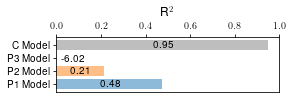

In [13]:
fig, ax = plt.subplots(figsize=(4,1))
p = ax.barh([lab+' Model' for lab in barLab], rsq, color=colVals, alpha=0.5)
ax.bar_label(p, fmt='%.2f', label_type='center')
ax.text(0.02, 2-0.25, f'{rsq[2]:.2f}')
ax.set_title('R$^2$')
ax.set_xlim(0, 1)
ax.xaxis.tick_top()

# p = ax[0].barh(barLab, [len(y_train[idx])+len(y_test[idx]) for idx,_ in enumerate(y_test)], color=colVals, alpha=0.5)


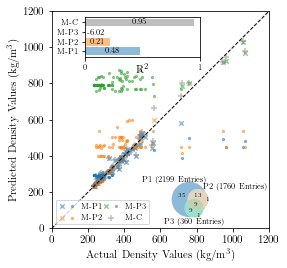

In [55]:
fig, ax1 = plt.subplots(figsize=(4,4))
samps = df[['compVec', 'density kg/m^3', 'provider']].sample(n=100, random_state=3)
compVecSamps = list(samps['compVec'])
actDens = list(samps['density kg/m^3'])
sampProvs = list(samps['provider'])

mkrSize1 = 20
mkrSize2 = 5
p = []
for idx, model in enumerate(models):
    if idx != 3:   
        p.append(ax1.scatter(samps['density kg/m^3'][samps['provider']==providerList[idx]],
                      model.predict(list(samps['compVec'][samps['provider']==providerList[idx]])),
                      s=mkrSize1, alpha=0.5, edgecolors=None, marker = 'x'))
    else:
        p.append(ax1.scatter(samps['density kg/m^3'],
                      model.predict(list(samps['compVec'])),
                      s=mkrSize1*2, alpha=0.5, edgecolors=None, marker = '+', fc='tab:grey'))

plt.gca().set_prop_cycle(None)
for idx, model in enumerate(models[:-1]):
    p.append(ax1.scatter(samps['density kg/m^3'][samps['provider']!=providerList[idx]],
                  model.predict(list(samps['compVec'][samps['provider']!=providerList[idx]])),
                  s=mkrSize2, alpha=0.5, edgecolors=None, marker = 'o'))


ax1.plot((0,1200), (0, 1200), 'k--', linewidth=1)

ax1.axis('tight')

ax1.set_ylabel('Predicted Density Values (kg/m$^3$)')
ax1.set_xlabel('Actual Density Values (kg/m$^3$)')
ax1.legend([(p[0], p[4]), (p[1], p[5]), (p[2], p[6]), p[3]], ['M-'+lab for lab in barLab],
           handler_map = {tuple: HandlerTuple(None)},
          loc='lower left', ncol=2, columnspacing=0.1, prop={'size': 8})
ax1.axis('equal')
ax1.axis('tight')
ax1.axis('square')
ax1.set_xlim(0, 1200)
ax1.set_ylim(0, 1200)

ax2 = fig.add_axes([0.25, 0.72, 0.4, 0.14])
p = ax2.barh(['M-'+lab for lab in barLab], rsq, color=colVals, alpha=0.5)
ax2.bar_label(p, fmt='%.2f', label_type='center', fontsize=8)
ax2.text(0.02, 2-0.25, f'{rsq[2]:.2f}', fontsize=8)
ax2.set_xlim(0, 1)
ax2.set_xticks([0, 1])
ax2.set_xlabel('R$^2$')
ax2.xaxis.set_label_coords(0.5, -0.2)
ax2.tick_params(labelsize=8)
# ax2.xaxis.tick_top()

# plt.show()
ax3 = fig.add_axes([0.54, 0.15, 0.15, 0.15])
v = vn.venn3([setElems[0], setElems[1], setElems[2]], barLab, set_colors=colVals, alpha=0.5, ax=ax3)
# ax.set_title('Unique elements')
plt.subplots_adjust(hspace=0.5)

v.get_label_by_id('A').set_text(f'P1 ({len(y_train[0])+len(y_test[0])} Entries)')
v.get_label_by_id('B').set_text(f'P2 ({len(y_train[1])+len(y_test[1])} Entries)')
v.get_label_by_id('C').set_text(f'P3 ({len(y_train[2])+len(y_test[2])} Entries)')

v.get_label_by_id('A').set_x(0.5)
for text in v.set_labels:
    text.set_fontsize(8)
for text in v.subset_labels:
    try:
        text.set_fontsize(6)
    except:
        continue

plt.savefig('scatterPlot.pdf', bbox_inches='tight')

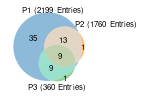

In [15]:
fig, ax = plt.subplots(1, figsize=(1.5,1.5))
# p = ax[0].barh(barLab, [len(y_train[idx])+len(y_test[idx]) for idx,_ in enumerate(y_test)], color=colVals, alpha=0.5)
# ax[0].bar_label(p, fmt='%.2d', label_type='center')
# ax[0].set_title('Number of materials')
# ax[0].xaxis.tick_top()

v = vn.venn3([setElems[0], setElems[1], setElems[2]], barLab, set_colors=colVals, alpha=0.5, ax=ax)
# ax.set_title('Unique elements')
plt.subplots_adjust(hspace=0.5)
plt.savefig('countVenn.pdf', bbox_inches='tight')

v.get_label_by_id('A').set_text(f'P1 ({len(y_train[0])+len(y_test[0])} Entries)')
v.get_label_by_id('B').set_text(f'P2 ({len(y_train[1])+len(y_test[1])} Entries)')
v.get_label_by_id('C').set_text(f'P3 ({len(y_train[2])+len(y_test[2])} Entries)')

v.get_label_by_id('A').set_x(0.5)
for text in v.set_labels:
    text.set_fontsize(8)
for text in v.subset_labels:
    try:
        text.set_fontsize(8)
    except:
        continue